# Examine Traits of Users

This notebook first examines our population a couple different ways -- first, ..

We are most interested in geotagging tweets, so that happens next.

In [57]:
import pandas as pd
import numpy as np
import geopandas as gpd
import utils.common.constants as c
import matplotlib.pyplot as plt
from sqlitedict import SqliteDict
from pyarrow import feather

from utils.data_analysis import (
    load_edges,
    load_users,
    load_places,
    load_locations,
    load_tweets
)

In [ ]:
tweets_df, geo_tweets_df = load_tweets.load_tweets_dfs()
tweets_df.head()

In [ ]:
geo_tweets_df.head()

Determine what % of recorded tweets are geotagged:

In [4]:
100 * geo_tweets_df["Tw_ID"].count() / tweets_df["Tw_ID"].count()

0.5974868075083968

## Load Users, Locations, Places dataframe

* users_df = all users
* geo_users_df = those users who had a geotagged #BLM tweet
* places_df = all geotagged (BLM or otherwise) tweets from geo_users
* locs_gdf = the calculated locations of geo_users, excluding foreign, unknown locations (*gdf = geo-enabled dataframe*)

In [ ]:
users_df, geo_users_df = load_users.load_users_dfs()
users_df.head()

In [6]:
geo_users_df.describe()

,Following,Followers,Tweets,Locations
count,70251.000000,7.025100e+04,7.025100e+04,70251.000000
mean,1179.279583,3.335352e+03,1.693006e+04,1.769299
std,4982.973276,5.272600e+04,3.738837e+04,1.629951
min,0.000000,0.000000e+00,1.000000e+00,1.000000
25%,278.000000,1.820000e+02,1.891000e+03,1.000000
50%,591.000000,4.660000e+02,6.133000e+03,1.000000
75%,1240.000000,1.229000e+03,1.745850e+04,2.000000
max,923328.000000,6.848484e+06,2.355436e+06,87.000000


In [ ]:
places_df = load_places.load_places_df()
places_df.head()

In [8]:
pl = places_df.groupby(["U_ID", "PL_ID"]).agg({
    "Twts": "first"
})
pl["Twts"] = pl["Twts"].apply(lambda x: len(x))
pl.reset_index(inplace=True)
pl.groupby("U_ID").agg({
    "Twts": "sum"
}).describe()

,Twts
count,70383.000000
mean,36.906497
std,87.133786
min,1.000000
25%,4.000000
50%,11.000000
75%,33.000000
max,4379.000000


In [ ]:
locs_gdf = load_locations.load_locations_gdf()
locs_gdf.head()

## Examine User Mean Information

In [10]:
users_df.describe()

,Following,Followers,Tweets,Locations
count,6.159999e+06,6.159999e+06,6.159999e+06,6.159999e+06
mean,7.795540e+02,2.276708e+03,2.011490e+04,2.017776e-02
std,3.109806e+03,1.110351e+05,4.373095e+04,2.561082e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00
25%,1.680000e+02,7.700000e+01,1.584000e+03,0.000000e+00
50%,3.660000e+02,2.440000e+02,6.434000e+03,0.000000e+00
75%,7.880000e+02,6.750000e+02,2.045500e+04,0.000000e+00
max,2.763614e+06,1.087691e+08,5.779644e+06,8.700000e+01


In [11]:
geo_users_df.describe()

,Following,Followers,Tweets,Locations
count,70251.000000,7.025100e+04,7.025100e+04,70251.000000
mean,1179.279583,3.335352e+03,1.693006e+04,1.769299
std,4982.973276,5.272600e+04,3.738837e+04,1.629951
min,0.000000,0.000000e+00,1.000000e+00,1.000000
25%,278.000000,1.820000e+02,1.891000e+03,1.000000
50%,591.000000,4.660000e+02,6.133000e+03,1.000000
75%,1240.000000,1.229000e+03,1.745850e+04,2.000000
max,923328.000000,6.848484e+06,2.355436e+06,87.000000


## Examine the Places Geotagged Users are At

load_places_df generates a dataframe with each place geotagged by each user, along with the IDs of the tweets containing these geotags.

First, we view the most frequently occuring places in our dataset. 

We also look at how common the different places logged by Twitter are at a highly granular level. Twitter allows as large locations as a country, or as specific as a single restaurant. Admin stands for administrative region. In the United States, that usually refers to a state but also territories.

In [ ]:
places_df[c.NUM_TWEETS] = places_df[c.NUM_TWEETS].apply(len)
places_agg_df = places_df.groupby(c.PL_ID).agg({
  c.PL_NAME: 'first', 
  c.PL_TYPE: 'first', 
  c.C_CODE: 'first', 
  c.U_ID: 'count',
  c.NUM_TWEETS: 'sum',
})
places_agg_df.sort_values(by=c.U_ID, axis=0, ascending=False, inplace=True)
places_agg_df

In [13]:
places_df.groupby('Type').agg({
    "Twts": "sum"
})

,Twts
Type,
admin,259109
city,2220881
country,99443
neighborhood,3619
poi,14538


# Examine User Locations

I use the term "locations" to denote the place a user is most often geotagged at. I only assign locations to users whose mean place -- a point where the X-coordinate is the weighted avg. of all X- coordinates and the Y-coordinate is the weighted avg. of all Y- coordinates they are tagged at -- is less than 30km away from modal location. This allows for users to vary somewhat (i.e. by taking a day trip) while giving us reasonable confidence that their modal location represents their home.

View "discord" rate -- by how much did mean and mode location estimate differ?

In [14]:
discord_df = locs_gdf.groupby(locs_gdf[c.GEO_DEV]).agg({
      c.U_ID: 'count',
      c.NUM_TWEETS: 'mean',
    })
discord_df.reset_index(inplace=True)
discord_df

,mean-mode dev.,U_ID,Twts
0,0.000000e+00,13828,7.400130
1,4.547474e-13,2,6.500000
2,9.094947e-13,7,24.285714
3,1.818989e-12,14,44.642857
4,2.728484e-12,1,15.000000
...,...,...,...
12106,2.965236e+04,1,14.000000
12107,2.986066e+04,1,29.000000
12108,2.986398e+04,1,23.000000
12109,2.992598e+04,1,77.000000


In [15]:
perc_range = [0.1*x for x in range(1,10)]
locs_gdf.describe(percentiles=perc_range)

,PL_ID,Twts,mean-mode dev.
count,34443.000000,34443.000000,3.444300e+04
mean,1.655111,30.093343,1.580031e+03
std,1.330301,69.499044,3.956426e+03
min,1.000000,1.000000,0.000000e+00
10%,1.000000,1.000000,0.000000e+00
20%,1.000000,2.000000,0.000000e+00
30%,1.000000,4.000000,0.000000e+00
40%,1.000000,6.000000,0.000000e+00
50%,1.000000,9.000000,2.328306e-10
60%,1.000000,14.000000,4.656613e-10


     mean-mode dev.  U_ID
0               0.0   378
1             100.0   524
2             200.0   466
3             300.0   391
4             400.0   411
..              ...   ...
292         29400.0     3
293         29500.0     3
294         29600.0     2
295         29700.0     1
296         29900.0     4

[297 rows x 2 columns]


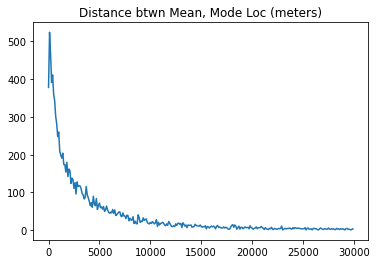

In [16]:
# First, create 'gdf_discord' based on number of users with each distance away.
discord_df = locs_gdf.groupby(locs_gdf[c.GEO_DEV]).agg({c.U_ID: 'count'})
discord_df.reset_index(inplace=True)

# Then, round all distances to nearest 100s.
discord_df[c.GEO_DEV] = discord_df[c.GEO_DEV].round(decimals=-2)
discord_df = discord_df.groupby(discord_df[c.GEO_DEV]).agg({c.U_ID: 'count'})
discord_df.reset_index(inplace=True)

print(discord_df)

# Finally, plot it:
plt.title("Distance btwn Mean, Mode Loc (meters)")
plt.plot(discord_df[c.GEO_DEV], discord_df[c.U_ID])

## Geotagging Behavior by Account Age

Group users by account age, and view the percentage of accounts with geotags at each birthdate. From this, we see that older users are more likely to be geotagged. 

This may speak to the fact that Geo tagging is more common among more invested Twitter users, who may have used the platform since the beginning. It may also represent changing norms as well as actual features released by Twitter, as Twitter has made Geo tagging opt out by default in more recent years.

In [17]:
def calcRange(num_locs_list):
    '''
    Convert the series for number of unique locations per user to a series representing string range.
    '''
    out = []
    for num_locs in num_locs_list:
        if num_locs == 0:
            out.append("0")
        elif num_locs < 2:
            out.append("1")
        elif num_locs < 5:
            out.append("2-4")
        elif num_locs < 10:
            out.append("5-9")
        elif num_locs < 20:
            out.append("10-19")
        else:
            out.append("20+")
    return out

Sort users based on birthday:

In [18]:
geo_users_by_bday_df = geo_users_df.groupby([
 geo_users_df[c.BORN].dt.year, 
]).agg({
  c.U_ID: 'count', 
  c.FLWNG: 'mean',
  c.LOCS: 'mean',
})

users_by_bday_df = users_df.groupby([
 users_df[c.BORN].dt.year, 
]).agg({
  c.U_ID: 'count', 
  c.FLWNG: 'mean',
  c.LOCS: 'mean',
})

users_by_bday_df

,U_ID,Following,Locations
Born,,,
1970,19,811.421053,0.000000
2006,748,2037.326203,0.054813
2007,13796,2006.246231,0.062772
2008,61495,1833.340515,0.058297
2009,429932,1292.566052,0.054790
2010,339325,1102.675373,0.037669
2011,495759,992.983526,0.032816
2012,494140,908.162399,0.024210
2013,443205,851.736273,0.021286


In [19]:
geo_users_by_bday_df.index.set_names(['year'], inplace=True)
users_by_bday_df.index.set_names(['year'], inplace=True)

geo_users_by_bday_df.reset_index(inplace=True)
users_by_bday_df.reset_index(inplace=True)

Merge with geo_users:

In [20]:
users_by_bday_df = users_by_bday_df.merge(
  geo_users_by_bday_df, 
  how='left', 
  on=['year'], 
  suffixes=[None, '_geo']
)
users_by_bday_df

,year,U_ID,Following,Locations,U_ID_geo,Following_geo,Locations_geo
0,1970,19,811.421053,0.000000,NaN,NaN,NaN
1,2006,748,2037.326203,0.054813,21.0,1989.809524,1.952381
2,2007,13796,2006.246231,0.062772,480.0,2528.485417,1.804167
3,2008,61495,1833.340515,0.058297,2039.0,2655.881314,1.758215
4,2009,429932,1292.566052,0.054790,13110.0,1509.538978,1.796796
5,2010,339325,1102.675373,0.037669,7208.0,1262.588097,1.773307
6,2011,495759,992.983526,0.032816,9112.0,1145.902875,1.785448
7,2012,494140,908.162399,0.024210,6825.0,1124.566740,1.752821
8,2013,443205,851.736273,0.021286,5352.0,1164.865658,1.762706
9,2014,449929,776.633780,0.019114,4750.0,1043.940211,1.810526


Sort out the 19 users "born" in 1970. This is likely a Twitter data discrepancy.

In [21]:
users_by_bday_df = users_by_bday_df[users_by_bday_df['year'] > 2000]
users_by_bday_df["U_ID_geo"] = users_by_bday_df["U_ID_geo"].fillna(0)

users_by_bday_df = users_by_bday_df.groupby(["year"]).agg({
    'U_ID': 'sum',
    'U_ID_geo': 'sum',
})

/var/folders/1t/8mlwmmq90_92z_5p64h7l54m0000gn/T/ipykernel_11125/1667853814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_by_bday_df["U_ID_geo"] = users_by_bday_df["U_ID_geo"].fillna(0)


In [22]:
PERC_GEO = "% with Geotags"

users_by_bday_df[PERC_GEO] = users_by_bday_df["U_ID_geo"].div(users_by_bday_df[c.U_ID])*100
users_by_bday_df

,U_ID,U_ID_geo,% with Geotags
year,,,
2006,748,21.0,2.807487
2007,13796,480.0,3.479269
2008,61495,2039.0,3.315717
2009,429932,13110.0,3.049319
2010,339325,7208.0,2.124217
2011,495759,9112.0,1.837990
2012,494140,6825.0,1.381188
2013,443205,5352.0,1.207568
2014,449929,4750.0,1.055722


Text(0.5, 1.0, 'Geotagging by Account Age')

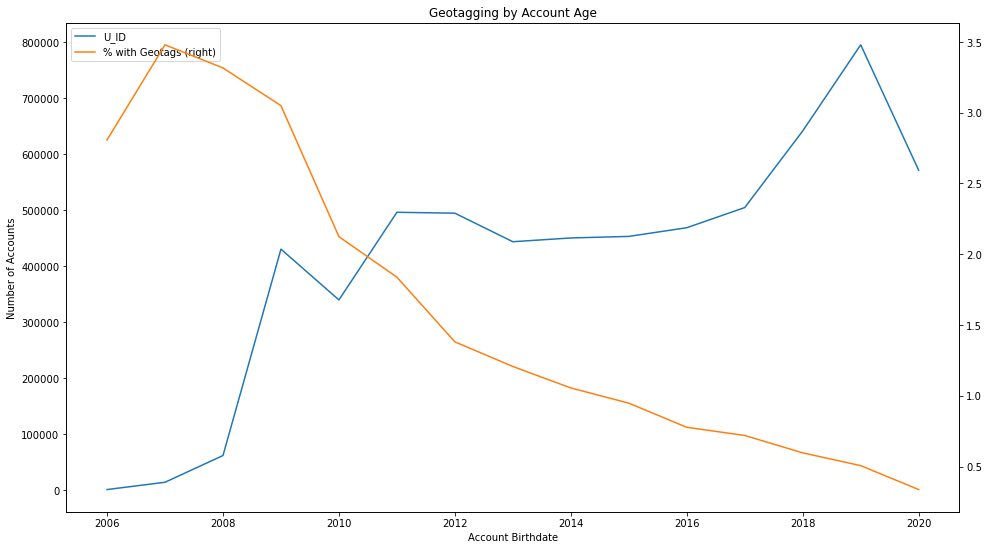

In [23]:
# Auto Range
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

users_by_bday_df.plot(use_index=True, y=[c.U_ID], ax=ax)
ax.set_ylabel("Number of Accounts")
users_by_bday_df.plot(ax=ax, use_index=True, y=[PERC_GEO], secondary_y=True)
ax.set_xlabel("Account Birthdate")
ax.set_title("Geotagging by Account Age")


# Examine Cumulative Adoptions over Time

Adoption is operationalized as first tweet by user in study period containing #BLM.

My `tweets_df` contains tweets stretching into the second week after Floyd's murder -- to limit scope, I focused on a single week (through June 1). Note that the tweet timestamps are represented in UTC.

In [24]:
tweets_df[tweets_df[c.CREATED_AT] < "06-01-2020 20:00:00"].groupby(c.U_ID).agg({
    c.CREATED_AT:"first",
}).count()


tweets_df[tweets_df[c.CREATED_AT] < "06-01-2020 20:00:00"].count()

Tw_ID        14176614
U_ID         14176614
Timestamp    14176614
Geos            70706
dtype: int64

,Timestamp,Tw_ID
27,2212-04-08 23:50:52.580896768-05:00,11323627
28,1678-02-17 04:20:18.871345152-04:56,11933816
29,1728-07-19 14:20:18.871345152-04:56,12752507
30,1778-12-19 06:20:18.871345152-04:56,13759601
31,1829-05-21 04:20:18.871345152-04:56,14176614


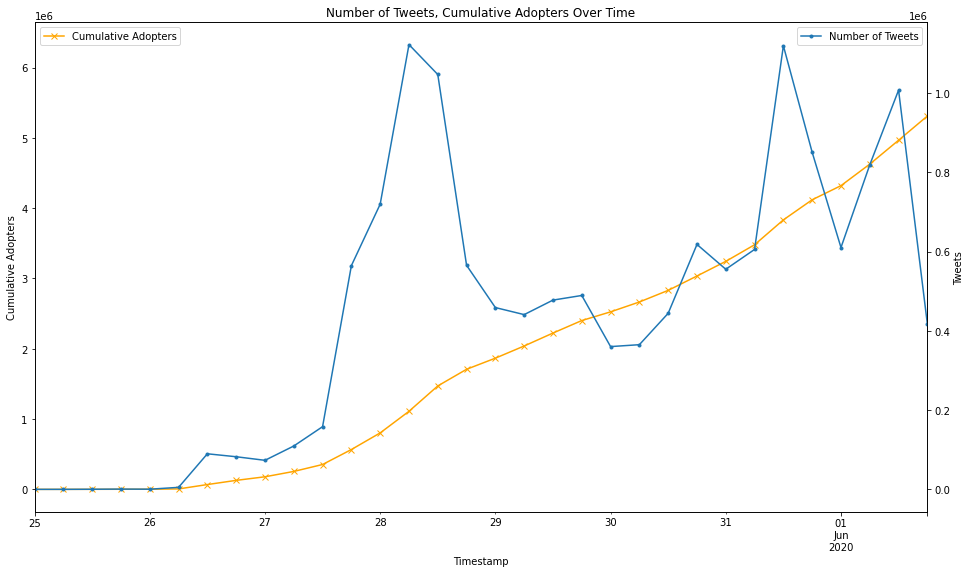

In [25]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

adptr_ct_df = tweets_df.groupby(c.U_ID).agg({
    c.CREATED_AT:"first",
})
adptr_ct_df.reset_index(inplace=True)
adptr_ct_df = adptr_ct_df.groupby(
    pd.Grouper(key=c.CREATED_AT, freq='6h')
).count().cumsum()

ax = adptr_ct_df.plot(y="U_ID",ax=ax, color="orange", marker="x", label="Cumulative Adopters")
ax.set_ylabel("Cumulative Adopters")

ax2 = ax.twinx()
ax2.set_ylabel("Tweets")
ax2.set_xlabel("Time")

twts_grpd = tweets_df[tweets_df[c.CREATED_AT] < "06-01-2020 20:00:00"].groupby(
    pd.Grouper(key=c.CREATED_AT, freq='6h')
).agg({
    "Tw_ID": "count"
})
twts_grpd.reset_index(inplace=True)

twts_grpd.plot(x=c.CREATED_AT, y="Tw_ID", marker=".", ax=ax2, label="Number of Tweets")

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_title("Number of Tweets, Cumulative Adopters Over Time")

twts_grpd.cumsum().tail()

## Adoption over Time among Users, Geotagged Users, Minnesota Users

Graph rate of geotagged tweets and perecent geotagged by time, to determine if the adoption rates between user types is substantial. 

We find that Minnesota adopters tended to adopt much earlier in the study, while foreign adopters tended to adopt towards the end of the study, demonstrating a bit of a geographic spread. We also see that Geo tagged users often adopted in the early stage, which may speak to the fact that they tend to be more online and more connected on Twitter.

In [26]:
geo_users_w_info_gdf = gpd.read_feather("utils/data_analysis/feathers/geo_users_w_info_gdf.ftr")
geo_users_w_info_gdf.describe()

,mean-mode dev.,Geo_FIPS,Geo_STATE,Total_Pop,Pop_Dens,Land_Area,WhitePop,BlackPop,OtherRacePop,WhitePopPerc,...,Following,Followers,Tweets,Pop_Dens_std,PKPerSqMile_std,WhitePopPerc_std,BlackPopPerc_std,WhitePerCap_std,BlackPerCap_std,cluster_label
count,3.437900e+04,3.437900e+04,34379.000000,3.437900e+04,34300.000000,34300.000000,3.437900e+04,34379.000000,3.437900e+04,34379.000000,...,34379.000000,3.437900e+04,3.437900e+04,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000,34379.000000
mean,1.579819e+03,2.598706e+09,25.902382,8.556566e+05,8036.880040,192.025560,4.641589e+05,156743.689229,2.347540e+05,61.736517,...,1196.417231,3.282625e+03,1.658021e+04,0.680125,0.770593,-0.538963,0.341629,0.542345,0.036051,2.859624
std,3.955855e+03,1.652377e+09,16.489786,9.993318e+05,13604.529302,466.710048,5.485587e+05,221619.030296,3.245024e+05,18.226162,...,4387.541000,5.706542e+04,3.645231e+04,1.949278,1.363909,0.919040,1.058868,1.318129,0.796388,1.589941
min,0.000000e+00,1.001926e+08,1.000000,1.660000e+02,0.434984,0.032625,1.630000e+02,0.000000,0.000000e+00,1.380000,...,0.000000,0.000000e+00,1.000000e+00,-0.470243,-0.579824,-3.582392,-0.812009,-2.354235,-2.211264,0.000000
25%,0.000000e+00,9.001336e+08,9.000000,8.099300e+04,1933.357000,36.339705,5.553000e+04,6863.500000,9.244500e+03,47.780000,...,290.000000,1.900000e+02,2.039000e+03,-0.193044,-0.380999,-1.242709,-0.442123,-0.275905,-0.490059,2.000000
50%,2.328306e-10,2.605938e+09,26.000000,3.957770e+05,3570.421000,87.658840,2.094240e+05,45888.000000,6.624500e+04,60.300000,...,597.000000,4.600000e+02,6.379000e+03,0.041726,0.326842,-0.611399,-0.051758,0.299761,-0.035321,3.000000
75%,9.275834e+02,3.906102e+09,39.000000,1.579075e+06,9067.710000,235.938329,7.563910e+05,240993.000000,4.233490e+05,76.380000,...,1227.000000,1.169000e+03,1.745500e+04,0.830088,1.719667,0.199423,0.997745,0.822849,0.353585,4.000000
max,2.993679e+04,7.214985e+09,72.000000,3.433961e+06,71488.690000,24607.898341,2.556502e+06,833683.000000,1.050342e+06,100.000000,...,362676.000000,6.848484e+06,2.355436e+06,9.781831,21.214474,1.390442,5.225198,8.394457,14.464471,5.000000


Assemble Minnesota tweets DF:

In [ ]:
geo_user_twts_df = tweets_df.merge(geo_users_w_info_gdf[[c.U_ID, "Geo_STATE"]].astype(int), how="left", on=c.U_ID)
geo_user_twts_df = geo_user_twts_df.loc[geo_user_twts_df["Geo_STATE"].notna(), :]
mn_tweets_df = geo_user_twts_df.loc[geo_user_twts_df["Geo_STATE"]==27.0, :]
mn_tweets_df

Assemble adopter by hour sequences:

In [28]:
adptr_ct_df = tweets_df.groupby(c.U_ID).agg({
    c.CREATED_AT:"first",
})
adptr_ct_df.reset_index(inplace=True)
adptr_ct_df = adptr_ct_df.groupby(
    pd.Grouper(key=c.CREATED_AT, freq='1h')
).count().cumsum()

###
geo_adptr_ct_df = geo_user_twts_df.groupby(c.U_ID).agg({
    c.CREATED_AT:"first",
})
geo_adptr_ct_df.reset_index(inplace=True)
geo_adptr_ct_df = geo_adptr_ct_df.groupby(
    pd.Grouper(key=c.CREATED_AT, freq='1h')
).count().cumsum()

###
mn_adptr_ct_df = mn_tweets_df.groupby(c.U_ID).agg({
    c.CREATED_AT:"first",
})
mn_adptr_ct_df.reset_index(inplace=True)
mn_adptr_ct_df = mn_adptr_ct_df.groupby(
    pd.Grouper(key=c.CREATED_AT, freq='1h')
).count().cumsum()
mn_adptr_ct_df

,U_ID
Timestamp,
2020-05-26 08:00:00-04:00,1
2020-05-26 09:00:00-04:00,5
2020-05-26 10:00:00-04:00,12
2020-05-26 11:00:00-04:00,16
2020-05-26 12:00:00-04:00,27
...,...
2020-06-02 15:00:00-04:00,767
2020-06-02 16:00:00-04:00,771
2020-06-02 17:00:00-04:00,772


<AxesSubplot:xlabel='Timestamp'>

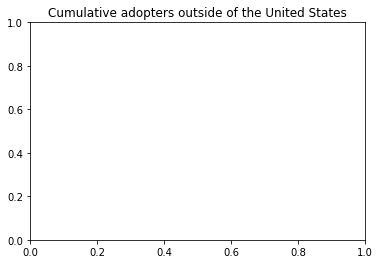

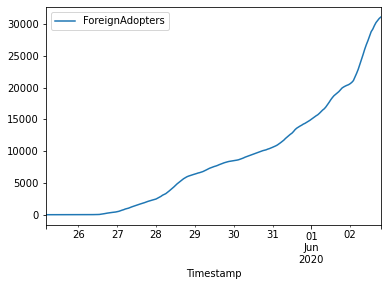

In [29]:
places_df = load_places.load_places_df()
places_df = places_df.explode('Twts')
places_df["Twts"] = places_df["Twts"].astype(int)

tweets_df, _ = load_tweets.load_tweets_dfs()
tweets_df = tweets_df.merge(places_df[["Twts","Country"]], how="left",left_on="Tw_ID", right_on="Twts")
tweets_df.head()

tweets_df["HaveNonUS"] = (~(tweets_df["Country"]=="US") & tweets_df["Country"].notna())

# look at the first BLM tweet among users with at least one tweet outside of the United States.
twts_grpd = tweets_df.groupby("U_ID").agg({
    "HaveNonUS": "any",
    "Timestamp": "first"
})
twts_grpd.reset_index(inplace=True)
foreign_adopt_count = twts_grpd.loc[twts_grpd["HaveNonUS"], :].groupby(
    pd.Grouper(key="Timestamp", freq='1h')
).agg({
    "U_ID": "count"
})
foreign_adopt_count["ForeignAdopters"] = foreign_adopt_count["U_ID"].cumsum()

plt.title("Cumulative adopters outside of the United States")
foreign_adopt_count.plot(use_index=True, y="ForeignAdopters")

In [30]:
foreign_adopt_count

,U_ID,ForeignAdopters
Timestamp,,
2020-05-25 04:00:00-04:00,1,1
2020-05-25 05:00:00-04:00,0,1
2020-05-25 06:00:00-04:00,0,1
2020-05-25 07:00:00-04:00,1,2
2020-05-25 08:00:00-04:00,0,2
...,...,...
2020-06-02 15:00:00-04:00,560,29761
2020-06-02 16:00:00-04:00,476,30237
2020-06-02 17:00:00-04:00,318,30555


In [31]:
adptr_ct_df.rename(columns={c.U_ID: "AllAdopters"}, inplace=True)
geo_adptr_ct_df.rename(columns={c.U_ID: "GeoAdopters"}, inplace=True)
mn_adptr_ct_df.rename(columns={c.U_ID: "MnAdopters"}, inplace=True)

adptr_ct_df = adptr_ct_df.merge(geo_adptr_ct_df, how="left", right_index=True, left_index=True)
adptr_ct_df = adptr_ct_df.merge(mn_adptr_ct_df, how="left", right_index=True, left_index=True)
adptr_ct_df = adptr_ct_df.merge(foreign_adopt_count, how="left", right_index=True, left_index=True)
adptr_ct_df

,AllAdopters,GeoAdopters,MnAdopters,U_ID,ForeignAdopters
Timestamp,,,,,
2020-05-25 00:00:00-04:00,41,NaN,NaN,NaN,NaN
2020-05-25 01:00:00-04:00,68,1.0,NaN,NaN,NaN
2020-05-25 02:00:00-04:00,115,3.0,NaN,NaN,NaN
2020-05-25 03:00:00-04:00,132,4.0,NaN,NaN,NaN
2020-05-25 04:00:00-04:00,150,6.0,NaN,1.0,1.0
...,...,...,...,...,...
2020-06-02 15:00:00-04:00,6125652,33375.0,767.0,560.0,29761.0
2020-06-02 16:00:00-04:00,6184660,33670.0,771.0,476.0,30237.0
2020-06-02 17:00:00-04:00,6236230,33856.0,772.0,318.0,30555.0


In [32]:
for col in adptr_ct_df.columns:
    adptr_ct_df[col] = adptr_ct_df[col].div(adptr_ct_df[col].max())

adptr_ct_df

,AllAdopters,GeoAdopters,MnAdopters,U_ID,ForeignAdopters
Timestamp,,,,,
2020-05-25 00:00:00-04:00,0.000006,NaN,NaN,NaN,NaN
2020-05-25 01:00:00-04:00,0.000011,0.000029,NaN,NaN,NaN
2020-05-25 02:00:00-04:00,0.000018,0.000087,NaN,NaN,NaN
2020-05-25 03:00:00-04:00,0.000021,0.000116,NaN,NaN,NaN
2020-05-25 04:00:00-04:00,0.000024,0.000175,NaN,0.001211,0.000032
...,...,...,...,...,...
2020-06-02 15:00:00-04:00,0.968346,0.970796,0.983333,0.677966,0.956853
2020-06-02 16:00:00-04:00,0.977674,0.979377,0.988462,0.576271,0.972157
2020-06-02 17:00:00-04:00,0.985826,0.984787,0.989744,0.384988,0.982381


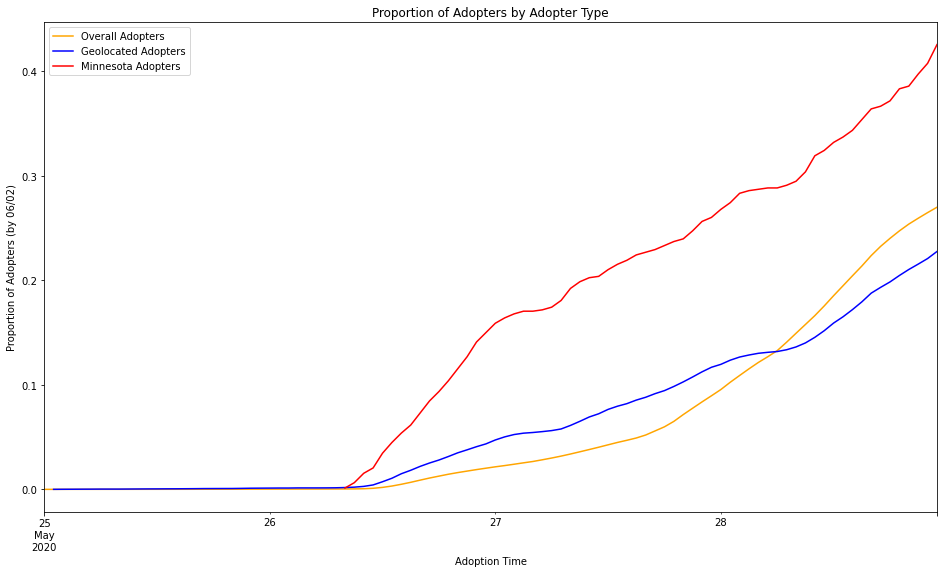

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

adptr_ct_df.loc[adptr_ct_df.index < "2020-05-29"].plot(y="AllAdopters",ax=ax, color="orange", label="Overall Adopters")
adptr_ct_df.loc[adptr_ct_df.index < "2020-05-29"].plot(y="GeoAdopters",ax=ax, color="blue", label="Geolocated Adopters")
# adptr_ct_df.loc[adptr_ct_df.index < "2020-05-29"].plot(y="MnAdopters",ax=ax, color="red", label="Minnesota Adopters")
adptr_ct_df.loc[adptr_ct_df.index < "2020-05-29"].plot(y="MnAdopters",ax=ax, color="red", label="Minnesota Adopters")

ax.set_xlabel("Adoption Time")
ax.set_ylabel("Proportion of Adopters (by 06/02)")
ax.set_title("Proportion of Adopters by Adopter Type")
ax.legend()

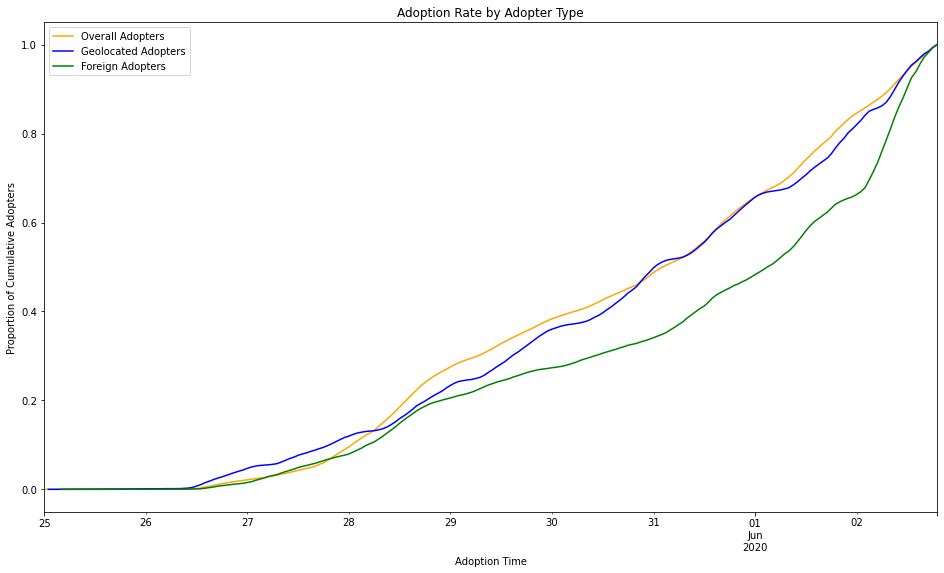

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

adptr_ct_df.plot(y="AllAdopters",ax=ax, color="orange",  label="Overall Adopters")
adptr_ct_df.plot(y="GeoAdopters",ax=ax, color="blue",  label="Geolocated Adopters")
# adptr_ct_df.plot(y="MnAdopters",ax=ax, color="red",  label="Minnesota Adopters")
adptr_ct_df.plot(y="ForeignAdopters",ax=ax, color="green", label="Foreign Adopters")


ax.set_xlabel("Adoption Time")
ax.set_ylabel("Proportion of Cumulative Adopters")
ax.set_title("Adoption Rate by Adopter Type")
ax.legend()

In [35]:
df = adptr_ct_df.reset_index()
df.groupby(
    pd.Grouper(key="Timestamp", freq='12h')
).first()

,AllAdopters,GeoAdopters,MnAdopters,U_ID,ForeignAdopters
Timestamp,,,,,
2020-05-25 00:00:00-04:00,0.000006,0.000029,NaN,0.001211,0.000032
2020-05-25 12:00:00-04:00,0.000063,0.000465,NaN,0.001211,0.000096
2020-05-26 00:00:00-04:00,0.000253,0.001222,0.001282,0.003632,0.000322
2020-05-26 12:00:00-04:00,0.001892,0.007301,0.034615,0.013317,0.001093
2020-05-27 00:00:00-04:00,0.021574,0.047267,0.158974,0.064165,0.015433
2020-05-27 12:00:00-04:00,0.042636,0.076529,0.210256,0.131961,0.049031
2020-05-28 00:00:00-04:00,0.095527,0.119637,0.267949,0.096852,0.079478
2020-05-28 12:00:00-04:00,0.185365,0.159167,0.332051,0.308717,0.148603
2020-05-29 00:00:00-04:00,0.275166,0.233689,0.435897,0.083535,0.205446


## Download Tweet Count by Time

In [36]:
tweets_df.groupby(
    pd.Grouper(key=c.CREATED_AT, freq='1h')
).count().to_csv("twts_raw_count.csv")

## Follower/Following By Tweet Timestamp

Here are examine the Netwerk centrality properties of users who adopted a different times in the study. Network theory has identified that the centrality of users is a critical feature of any propagation to the network.

In [ ]:
users_df[c.U_ID] = users_df[c.U_ID].astype(int)
users_df.head()

In [38]:
twts_w_user_info_df = tweets_df.merge(users_df, how="left", on=c.U_ID)
twts_w_user_info_df = twts_w_user_info_df.groupby(c.U_ID).agg({
    'Followers': 'first',
    'Following': 'first',
    'Born': 'first',
    'prior_adopter': 'first',
    'Tweets': 'first',
    c.CREATED_AT: "first"
})
twts_w_user_info_df.reset_index(inplace=True)
twts_w_user_info_df = twts_w_user_info_df.groupby(
    pd.Grouper(key=c.CREATED_AT, freq='24h')
).agg({
    'Followers': 'median',
    'Following': 'median',
    'Born': 'median',
    'prior_adopter': 'mean',
    "Tweets": 'median'
})

In [ ]:
twts_w_user_info_df

In [40]:
twts_w_user_info_df.plot(y='Tweets', use_index=True, ax=ax, label="Median Tweets")

<AxesSubplot:title={'center':'Adoption Rate by Adopter Type'}, xlabel='Timestamp', ylabel='Proportion of Cumulative Adopters'>

Text(0.5, 1.0, 'Median Characteristics of Adopters each Hour')

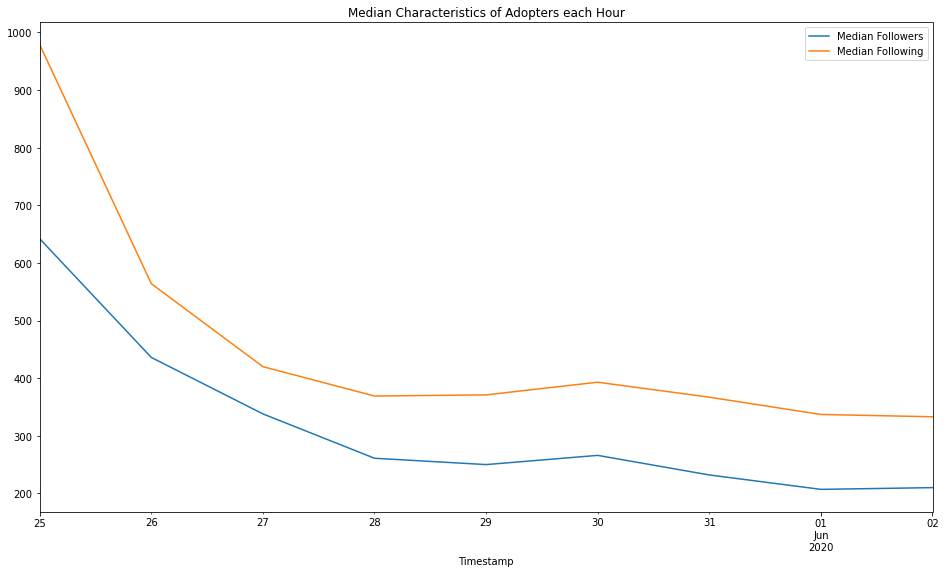

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

twts_w_user_info_df.plot(y='Followers', use_index=True, ax=ax, label="Median Followers")
twts_w_user_info_df.plot(y='Following', use_index=True, ax=ax, label="Median Following")
ax.set_title("Median Characteristics of Adopters each Hour")


,Followers,Following,Born,prior_adopter,Tweets
Timestamp,,,,,
2020-05-25 00:00:00-04:00,642.0,979.0,2014-03-16 22:58:16.500000+00:00,0.031908,22087.0
2020-05-26 00:00:00-04:00,436.0,564.0,2014-01-22 18:36:31+00:00,0.010145,14662.0
2020-05-27 00:00:00-04:00,338.0,420.0,2016-05-08 18:03:42+00:00,0.004293,11077.0
2020-05-28 00:00:00-04:00,261.0,369.0,2017-01-03 21:01:13+00:00,0.001855,9880.0
2020-05-29 00:00:00-04:00,250.0,371.0,2015-07-11 07:37:23+00:00,0.003219,7336.0
2020-05-30 00:00:00-04:00,266.0,393.0,2015-01-08 13:29:59+00:00,0.003273,7132.0
2020-05-31 00:00:00-04:00,232.0,367.0,2015-05-20 00:15:29+00:00,0.001933,5760.0
2020-06-01 00:00:00-04:00,207.0,337.0,2015-04-08 09:22:36+00:00,0.001453,4426.0
2020-06-02 00:00:00-04:00,210.0,333.0,2014-09-14 01:14:17+00:00,0.001817,3891.0


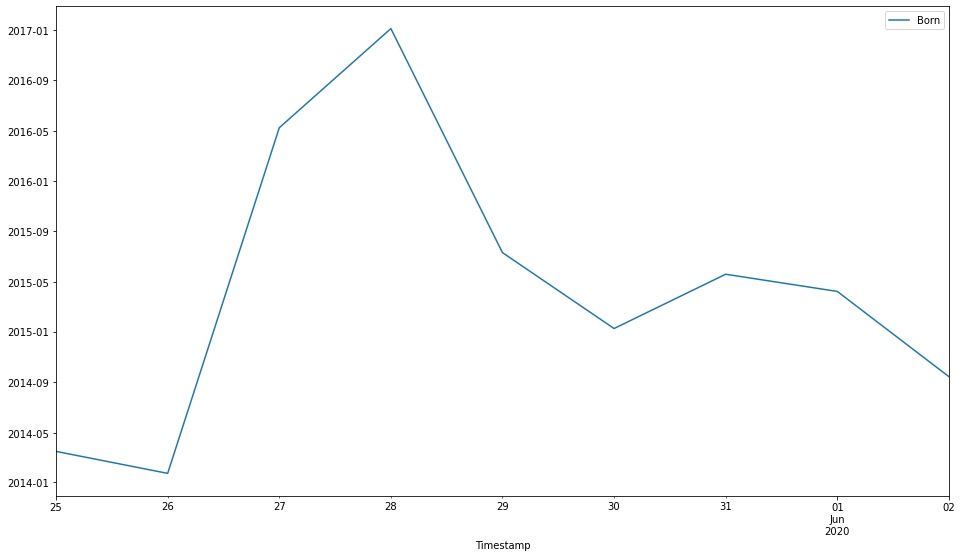

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
twts_w_user_info_df.plot(y='Born', use_index=True, ax=ax)
twts_w_user_info_df

In [43]:
twts_w_user_info_df.to_csv("mean_users_by_twts.csv")
adptr_ct_df.to_csv("twts_counts.csv")

### View Rates of adoption by country

A fuller examination of behavior across states and US regions can be found in the next Jupyter notebook.

In [44]:
countries_df = places_df.groupby("Country").agg({
    "Twts": "sum"
})
countries_df.sort_values(ascending=False, by="Twts").head(10)

,Twts
Country,
US,1.599363e+24
BR,3.813095e+23
GB,2.830797e+23
CA,9.476114e+22
NG,8.200682e+22
ZA,7.580157e+22
FR,5.318261e+22
IN,4.802946e+22
ES,4.591086e+22


In [45]:
countries_df.loc[:, "Twts"].sum() - countries_df.loc["US", "Twts"]

1.6917617597669323e+24

In [ ]:
expl_places_df = places_df.explode('Twts')
expl_places_df

In [ ]:
countries_grpd = places_df.groupby("U_ID").agg({"Country": lambda x: pd.Series.mode(x)[0]}) 
#  for users with more than one modal country, pick any
countries_grpd

In [108]:
country_counts_df = countries_grpd.reset_index().groupby("Country").count().reset_index()
country_counts_df.rename(columns={"Country":"Alpha-2Code"}, inplace=True)
country_counts_df

,Alpha-2Code,U_ID
0,,10
1,AD,3
2,AE,198
3,AF,8
4,AG,7
...,...,...
197,XK,7
198,YE,1
199,ZA,1165
200,ZM,62


In [109]:
country_codes_df = pd.read_csv("utils/data_analysis/datasets/country_codes.csv")
country_codes_df

,EnglishShort,Alpha-2Code,Alpha-3Code,NumericCode,ISO 3166-2
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX
2,Albania,AL,ALB,8,ISO 3166-2:AL
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ
4,American Samoa,AS,ASM,16,ISO 3166-2:AS
...,...,...,...,...,...
241,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF
242,Western Sahara,EH,ESH,732,ISO 3166-2:EH
243,Yemen,YE,YEM,887,ISO 3166-2:YE
244,Zambia,ZM,ZMB,894,ISO 3166-2:ZM


In [110]:
countries_df = country_codes_df[["EnglishShort", "Alpha-2Code"]].merge(country_counts_df, how="left", on="Alpha-2Code")
countries_df = countries_df.fillna(0)
countries_df.to_csv("country_counts_w_names.csv")
countries_df

,EnglishShort,Alpha-2Code,U_ID
0,Afghanistan,AF,8.0
1,Åland Islands,AX,0.0
2,Albania,AL,15.0
3,Algeria,DZ,18.0
4,American Samoa,AS,1.0
...,...,...,...
241,Wallis and Futuna,WF,0.0
242,Western Sahara,EH,0.0
243,Yemen,YE,1.0
244,Zambia,ZM,62.0
